# Boilerplate: Fine-Tuning Geospatial Foundation Model (Prithvi V2) for CropID
### CropID task for IBM-IISc Hackathon

### Install terratorch library from https://github.com/IBM/terratorch

In [1]:
!pip install terratorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 99.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.6/851.6 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
import albumentations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from albumentations.pytorch import ToTensorV2
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
from terratorch.tasks import SemanticSegmentationTask
import zipfile
import glob
import os

2025-09-17 17:06:05.370964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758128765.551084      74 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758128765.602205      74 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Dataset Configuration

In [3]:
dataset_path = '/kaggle/input/iisc-ibm-crop-id-segmentation'

datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=6,

    # Define dataset paths
    train_data_root=dataset_path+'/train/inputs',
    train_label_data_root=dataset_path+'/train/labels',
    val_data_root=dataset_path+'/val/inputs',
    val_label_data_root=dataset_path+'/val/labels',
    test_data_root=dataset_path+'/test/inputs',
    test_label_data_root=dataset_path+'/test/labels',

    # Define splits
    train_split="/kaggle/input/iisc-ibm-crop-id-segmentation/train.txt",
    val_split="/kaggle/input/iisc-ibm-crop-id-segmentation/val.txt",
    test_split="/kaggle/input/iisc-ibm-crop-id-segmentation/test.txt",

    img_grep='*input.tif',
    label_grep='*label_c6.tif',

    train_transform=[
        albumentations.D4(),
        ToTensorV2(),
    ],
    val_transform=None,
    test_transform=None,
    means = [43.377114, 38.762922, 37.587551, 39.397895, 42.61577, 54.785745, 63.259959, 59.998601, 13.367036, 69.212995, 48.322503, 69.708629],
    stds = [3.335747, 4.160813, 5.434037, 9.239101, 8.014329, 6.745426, 8.070073, 7.844921, 2.563382, 16.967517, 15.586694, 9.258978],
    no_data_replace=0,
    no_label_replace=-1,
)


datamodule.setup("fit")

### Dataset Summary

In [4]:

print("Train set size:", len(datamodule.train_dataset))
print("Validation set size:", len(datamodule.val_dataset))

datamodule.setup("test")
print("Test set size:", len(datamodule.test_dataset))


Train set size: 928
Validation set size: 119
Test set size: 126


### Plotting a few samples

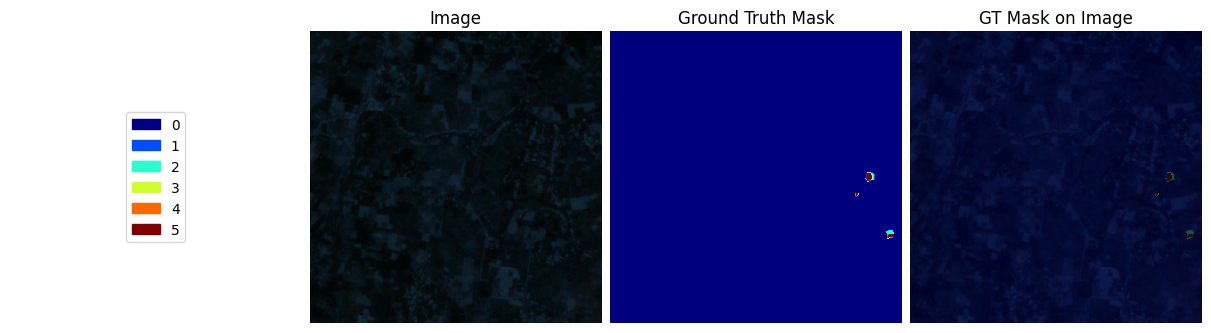

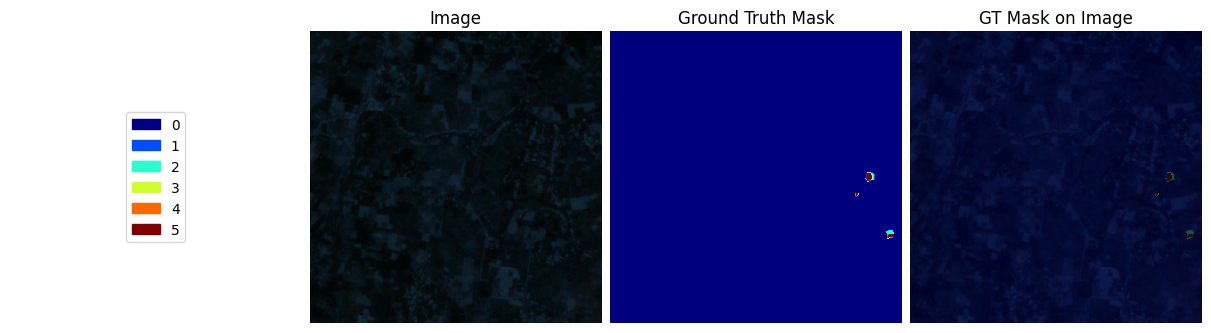

In [5]:
# Plot a sample from validation dataset
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

datamodule.val_dataset.plot(datamodule.val_dataset[10])


### Hyperparameters & Paths

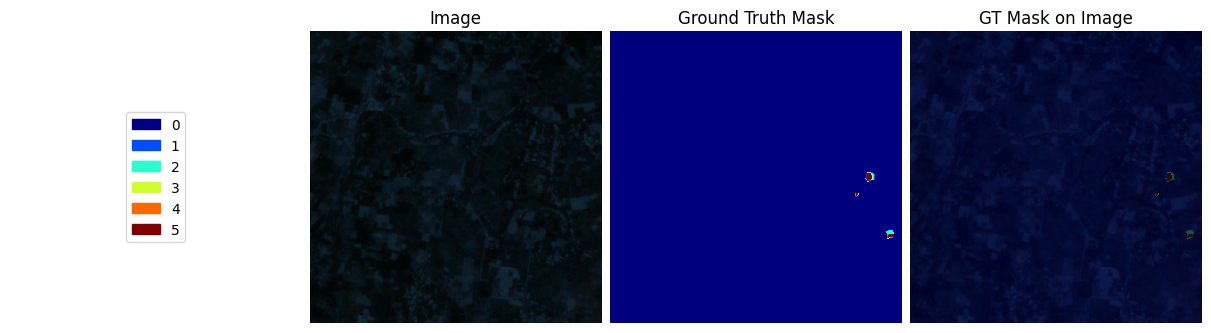

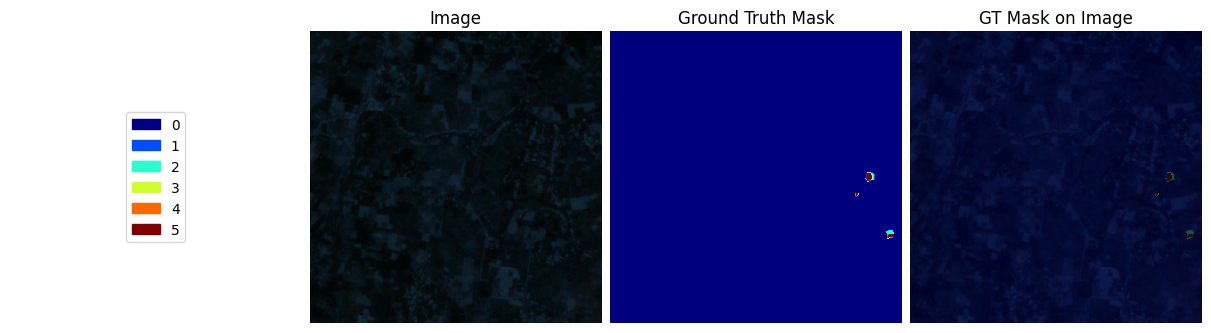

In [6]:
# plotting a few samples
datamodule.val_dataset.plot(datamodule.val_dataset[10])
#print(datamodule.val_dataset[10])

### Logging & Checkpointing

In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

OUT_DIR = "/kaggle/working"

BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-5
WEIGHT_DECAY = 0.1
HEAD_DROPOUT = 0.1
FREEZE_BACKBONE = False

BANDS =[1,2,3,4,5,6,7,8,9,10,11,12]
NUM_FRAMES = 1

#      Crop     Pixel_total    Pixel_percentage Class_weight
#      Gram        2545             1.73       0.4761
#     Maize        7128             4.84       0.1702
#   Mustard       36362            24.67       0.0334
# Sugarcane        4542             3.08       0.2674
#     Wheat       59585            40.42       0.0204
# OtherCrop       37247            25.27       0.0326

CLASS_WEIGHTS = [0.4761, 0.1702, 0.0334, 0.2674, 0.0204, 0.0326]

SEED = 0
pl.seed_everything(SEED)


INFO: Seed set to 0


0

In [8]:
SEED = 0

pl.seed_everything(SEED)

# Logger
logger = TensorBoardLogger(
    save_dir=OUT_DIR,
    name="cropid",
)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",
    mode="max",
    dirpath=os.path.join(OUT_DIR, "cropid", "checkpoints"),
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

INFO: Seed set to 0


In [9]:
from lightning.pytorch.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="val/Multiclass_Jaccard_Index",  # ✅ use this, it exists in logs
    mode="max",
    dirpath=os.path.join(OUT_DIR, "cropid", "checkpoints"),
    filename="best-checkpoint-{epoch:02d}-{val_jaccard:.2f}",
    save_top_k=1,
)


### Model Configuration

In [10]:
# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    precision="16-mixed",
    num_nodes=1,
    logger=logger,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    limit_predict_batches=1,  # predict only in the first batch for generating plots
)

# DataModule
data_module = datamodule


# Model

backbone_args = dict(
    backbone_pretrained=True,
    backbone="prithvi_eo_v2_300_tl", # prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
    #backbone_coords_encoding=["time", "location"],
    backbone_bands=BANDS,
    backbone_num_frames=1, # 1 is the default value,
)

decoder_args = dict(
    decoder="UperNetDecoder",
    decoder_channels=256,
    decoder_scale_modules=True
)

necks = [
    dict(
            name="ReshapeTokensToImage",
            effective_time_dim=NUM_FRAMES,
        )
    ]

model_args = dict(
    **backbone_args,
    **decoder_args,
    num_classes=6,
    head_dropout=HEAD_DROPOUT,
    necks=necks,
    rescale=True
)
    

model = SemanticSegmentationTask(
    model_args=model_args,
    plot_on_val=False,
    class_weights=CLASS_WEIGHTS,
    loss="dice",
    lr=LR,
    optimizer="AdamW",
    optimizer_hparams=dict(weight_decay=WEIGHT_DECAY),
    freeze_backbone=FREEZE_BACKBONE,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
    ignore_index = -1
)


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

Prithvi_EO_V2_300M_TL.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/terratorch/models/decoders/upernet_decoder.py:37: UserWarning: DeprecationWarning: scale_modules is deprecated and will be removed in future versions. Use LearnedInterpolateToPyramidal neck instead.
  warnings.warn(


In [11]:
trainer.fit(model, datamodule=datamodule)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 320 M  | train
1 | criterion     | DiceLoss         | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | ModuleList       | 0      | train
-----------------------------------------------------------
320 M     Trainable params
0         Non-trainable params
320 M     Total params
1,282.170 Total estimated model params size (MB)
621       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.


In [12]:
import glob, os

checkpoint_dir = "/kaggle/working/cropid/checkpoints"
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "best-checkpoint-*.ckpt"))

if len(checkpoint_files) == 0:
    raise FileNotFoundError("No best checkpoint file found in the directory.")

# Use the best saved checkpoint
best_ckpt_path = checkpoint_files[0]
print("Using checkpoint:", best_ckpt_path)

# Evaluate
test_results = trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)
print(test_results)


INFO: Restoring states from the checkpoint path at /kaggle/working/cropid/checkpoints/best-checkpoint-epoch=01-val_jaccard=0.00.ckpt


Using checkpoint: /kaggle/working/cropid/checkpoints/best-checkpoint-epoch=01-val_jaccard=0.00.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /kaggle/working/cropid/checkpoints/best-checkpoint-epoch=01-val_jaccard=0.00.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.5761758089065552          │
│      test/Multiclass_F1_Score       │         0.5761758089065552          │
│    test/Multiclass_Jaccard_Index    │         0.3051835298538208          │
│ test/Multiclass_Jaccard_Index_Micro │         0.40466782450675964         │
│              test/loss              │         0.36256346106529236         │
│      test/multiclassaccuracy_0      │                 0.0                 │
│      test/multiclassaccuracy_1      │          0.898245632648468          │
│      test/multiclassaccuracy_2      │         0.6320537328720093          │
│      test/multiclassaccuracy_3      │         0.25549131631851196         │
│      test/multiclassaccuracy_4      │         0.5746964812278748          │
│      test/multiclassaccuracy_5      │         0.6031768321990967          │
│    test/multiclassjaccardindex_0    │                 0.0                 │
│    test/multiclassjaccardindex_1    │         0.35522663593292236         │
│    test/multiclassjaccardindex_2    │         0.34205880761146545         │
│    test/multiclassjaccardindex_3    │         0.12679289281368256         │
│    test/multiclassjaccardindex_4    │         0.42312759160995483         │
│    test/multiclassjaccardindex_5    │         0.5838953256607056          │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 0.36256346106529236, 'test/Multiclass_Accuracy': 0.5761758089065552, 'test/multiclassaccuracy_0': 0.0, 'test/multiclassaccuracy_1': 0.898245632648468, 'test/multiclassaccuracy_2': 0.6320537328720093, 'test/multiclassaccuracy_3': 0.25549131631851196, 'test/multiclassaccuracy_4': 0.5746964812278748, 'test/multiclassaccuracy_5': 0.6031768321990967, 'test/Multiclass_F1_Score': 0.5761758089065552, 'test/Multiclass_Jaccard_Index': 0.3051835298538208, 'test/multiclassjaccardindex_0': 0.0, 'test/multiclassjaccardindex_1': 0.35522663593292236, 'test/multiclassjaccardindex_2': 0.34205880761146545, 'test/multiclassjaccardindex_3': 0.12679289281368256, 'test/multiclassjaccardindex_4': 0.42312759160995483, 'test/multiclassjaccardindex_5': 0.5838953256607056, 'test/Multiclass_Jaccard_Index_Micro': 0.40466782450675964}]


### Model Training

In [13]:

trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    precision="16-mixed",
    num_nodes=1,
    logger=logger,
    max_epochs=EPOCHS,
    check_val_every_n_epoch=1,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    limit_predict_batches=1,
)

trainer.fit(model, datamodule=datamodule)


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/cropid/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | PixelWiseModel   | 320 M  | train
1 | criterion     | DiceLoss         | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | ModuleList       | 0      | train
-----------------------------------------------------------
320 M     Trainable params
0         Non-trainable params
320 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.


Evalution valuation on Test Set

In [14]:
# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)   # <-- this fixes the mismatch


NameError: name 'torch' is not defined

In [ ]:
with torch.no_grad():
    outputs = model(images)
print(type(outputs))
print(outputs)


In [ ]:
with torch.no_grad():
    outputs = model(images)

# Access the tensor inside
preds = outputs.output.argmax(1).cpu()


In [ ]:
import torch
import matplotlib.pyplot as plt
import os

pred_dir = "/kaggle/working/test_predictions"
os.makedirs(pred_dir, exist_ok=True)

model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"

for i, batch in enumerate(datamodule.test_dataloader()):
    images, masks = batch['image'].to(device), batch['mask'].to(device)
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.output.argmax(1).cpu()   # ✅ fixed here

    for j in range(images.size(0)):
        pred = preds[j].numpy()
        plt.imsave(f"{pred_dir}/test_{i}_{j}.png", pred, cmap="tab20")

print("✅ Saved predictions in:", pred_dir)



In [ ]:
import shutil

# Make one clean folder for submission
import os
os.makedirs("/kaggle/working/final_submission", exist_ok=True)

# Copy only useful outputs (checkpoints + predictions + notebook if needed)
!cp -r /kaggle/working/cropid/checkpoints /kaggle/working/final_submission/
!cp -r /kaggle/working/test_predictions /kaggle/working/final_submission/
!cp /kaggle/working/*.ipynb /kaggle/working/final_submission/ || echo "No notebook found"

# Now zip the small folder
shutil.make_archive("/kaggle/working/final_submission", "zip", "/kaggle/working/final_submission")


In [ ]:

checkpoint_dir = "/kaggle/working/cropid/checkpoints"
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "best-checkpoint-*.ckpt"))

if len(checkpoint_files) == 0:
    raise FileNotFoundError("No best checkpoint file found in the directory.")
    
# Use the first match
best_ckpt_path = checkpoint_files[0]
test_results = trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)
print(test_results)


In [ ]:
!nvidia-smi


In [ ]:
CLASS_NAMES = ["background", "crop1", "crop2", "crop3", "crop4", "crop5"]


In [ ]:
for batch in datamodule.train_dataloader():
    masks = batch['mask']
    print("dtype:", masks.dtype)
    print("unique labels:", torch.unique(masks))
    break


In [ ]:
def remap_mask(mask):
    # clone to avoid modifying in place
    mask = mask.clone()
    mask[mask == -1] = 255   # special ignore index
    mask[mask == 1] = 0
    mask[mask == 2] = 1
    mask[mask == 3] = 2
    mask[mask == 4] = 3
    mask[mask == 5] = 4
    return mask


In [ ]:
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(CLASS_WEIGHTS[:5], dtype=torch.float32).to("cuda"),
    ignore_index=255   # ✅ now 255 is ignored
)


In [ ]:
batch = next(iter(datamodule.train_dataloader()))
masks = remap_mask(batch['mask'])
print("Unique labels after remap:", torch.unique(masks))


In [ ]:
for i, batch in enumerate(datamodule.train_dataloader()):
    masks = remap_mask(batch['mask'])
    print("Batch", i, "unique:", torch.unique(masks))
    if i == 5:  # check first 6 batches only
        break


In [15]:
# 1. Check class weights
print("CLASS_WEIGHTS length:", len(CLASS_WEIGHTS))
print("CLASS_WEIGHTS:", CLASS_WEIGHTS[:5])

# 2. Sanity check masks
batch = next(iter(datamodule.train_dataloader()))
masks = remap_mask(batch['mask'])
print("Unique labels after remap:", torch.unique(masks))


CLASS_WEIGHTS length: 6
CLASS_WEIGHTS: [0.4761, 0.1702, 0.0334, 0.2674, 0.0204]


NameError: name 'remap_mask' is not defined

In [ ]:
masks = remap_mask(masks).long()
masks[masks > 4] = 255   # anything outside 0..4 → ignore


In [ ]:
def clean_mask(m):
    m = m.clone().long()
    m[m > 4] = 255   # anything outside 0–4 → ignore
    m[m < 0] = 255   # negative values → ignore
    return m


In [ ]:
for batch in datamodule.train_dataloader():
    imgs, masks = batch['image'].to("cuda"), batch['mask']
    masks = remap_mask(masks)   # 1→0, 2→1, …, 5→4
    masks = clean_mask(masks).to("cuda")

    optimizer.zero_grad()
    out = baseline_model(imgs)
    loss = criterion(out, masks)
    loss.backward()
    optimizer.step()


In [ ]:
# =======================
# 1. Imports
# =======================
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn

# =======================
# 2. Remap masks: 1→0, 2→1, …, 5→4, keep -1 → 255
# =======================
def remap_mask(m):
    m = m.clone()
    m[m == -1] = 255     # no-data → 255
    m[m > 0] -= 1        # 1–5 → 0–4
    return m

# =======================
# 3. Model
# =======================
baseline_model = smp.Unet(
    encoder_name="resnet18",        # simple backbone
    encoder_weights="imagenet",     # pretrained
    in_channels=12,                 # 12-band input
    classes=5,                      # labels → 0..4
    activation=None
).to("cuda")

# =======================
# 4. Loss + Optimizer
# =======================
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(CLASS_WEIGHTS[:5], dtype=torch.float32).to("cuda"),
    ignore_index=255   # ✅ skip no-data pixels
)

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)

# =======================
# 5. Sanity check
# =======================
batch = next(iter(datamodule.train_dataloader()))
masks = remap_mask(batch['mask'])
print("✅ Sanity check labels:", torch.unique(masks))

# =======================
# 6. Training Loop
# =======================
for epoch in range(2):  # quick test, increase later
    baseline_model.train()
    running_loss = 0.0

    for batch in datamodule.train_dataloader():
        imgs, masks = batch['image'].to("cuda"), batch['mask'].to("cuda")
        masks = remap_mask(masks)   # ✅ fix labels

        optimizer.zero_grad()
        out = baseline_model(imgs)
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(datamodule.train_dataloader()):.4f}")


In [ ]:
def remap_and_clean_mask(m):
    m = m.clone()

    # Step 1: remap 1→0, 2→1, …, 5→4
    m[m > 0] -= 1

    # Step 2: ensure invalid pixels (-1 or 255) become 255
    m[(m < 0) | (m > 4)] = 255  

    return m


In [ ]:
batch = next(iter(datamodule.train_dataloader()))
masks = remap_and_clean_mask(batch['mask'])
print("Unique labels after full clean:", torch.unique(masks))


In [ ]:
device = "cpu"   # ✅ force CPU for debugging

baseline_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=12,
    classes=5,
    activation=None
).to(device)

criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(CLASS_WEIGHTS[:5], dtype=torch.float32).to(device),
    ignore_index=255
)

# train on just a few batches to test
for batch in datamodule.train_dataloader():
    imgs, masks = batch['image'].to(device), remap_mask(batch['mask']).to(device)
    out = baseline_model(imgs)
    loss = criterion(out, masks)
    print("Loss (CPU debug):", loss.item())
    break


In [ ]:
import os, gc, torch

# Clear cache
gc.collect()
torch.cuda.empty_cache()

# Reset CUDA
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Baseline UNet (5 classes)
baseline_model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=12,
    classes=5,
    activation=None
).to(device)

# ✅ Loss (ignore 255, weighted)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(CLASS_WEIGHTS[:5], dtype=torch.float32).to(device),
    ignore_index=255
)

optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)

# ==========================
# Helpers
# ==========================
def remap_mask(m):
    m = m.clone()
    m[m > 0] -= 1   # shift labels: 1→0, …, 5→4
    return m

def clean_mask(m):
    m = remap_mask(m)
    m[m < 0] = 255     # replace -1 with 255
    m[m > 4] = 255     # remove any stray values
    return m

# ==========================
# Training Loop
# ==========================
for epoch in range(2):
    baseline_model.train()
    running_loss = 0.0
    epoch_labels = set()

    for batch in datamodule.train_dataloader():
        imgs, masks = batch['image'].to(device), batch['mask']
        masks = clean_mask(masks).to(device)

        optimizer.zero_grad()
        out = baseline_model(imgs)
        loss = criterion(out, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_labels.update(torch.unique(masks).cpu().tolist())

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(datamodule.train_dataloader()):.4f}")
    print(f"Labels seen this epoch: {sorted(list(epoch_labels))}")
